<a href="https://colab.research.google.com/github/mayuresh23sawant/ds-ml/blob/master/RussianAirTraffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Russian Air Service Cargo Data



## Step 1: Imports and data download

In [ ]:
!pip install fastai2
!pip install utils
!pip install kaggle

In [2]:
from utils import *
from fastai2.vision.all import *

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d vitaliymalcev/russian-passenger-air-service-20072020

  0% 0.00/239k [00:00<?, ?B/s]
100% 239k/239k [00:00<00:00, 35.9MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

In [16]:
df=pd.read_csv('/content/russian_air_service_CARGO_AND_PARCELS.csv')
df.head()

,Airport name,Year,January,February,March,April,May,June,July,August,September,October,November,December,Whole year,Airport coordinates
0,Abakan,2020,43.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('91.399735'), Decimal('53.751351'))"
1,Aikhal,2020,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('111.543324'), Decimal('65.957161'))"
2,Loss,2020,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('125.398355'), Decimal('58.602489'))"
3,Amderma,2020,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('61.577429'), Decimal('69.759076'))"
4,Anadyr (Carbon),2020,122.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('177.738273'), Decimal('64.713433'))"


### Step 2: Data Preprocessing

Since the data is in the form of each columns given separately, I'll combine it into one single column. 

In [17]:
df = df.melt(id_vars = ['Airport name', 'Year'],
         value_vars = ['January', 'February', 'March', 'April', 'May','June', 'July', 'August', 'September', 'October', 'November','December'])

df.rename(columns = {'variable':'month', 'value':'cargo'}, inplace = True)

df.head(2)

,Airport name,Year,month,cargo
0,Abakan,2020,January,43.58
1,Aikhal,2020,January,0.00


In [18]:
df_per_year = df.groupby('Year')['cargo'].sum()
df_per_year = df_per_year.reset_index()

df_per_month = df.groupby('month')['cargo'].sum()
df_per_month = df_per_month.reset_index()

Let's see how the volume of cargo traffic depends oon the years and  on the months

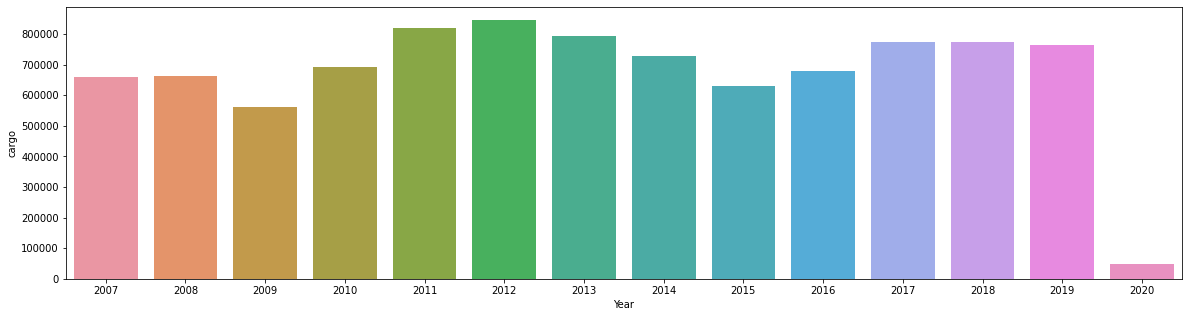

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(20,5))

sns.barplot(data = df_per_year, x = 'Year', y = 'cargo')

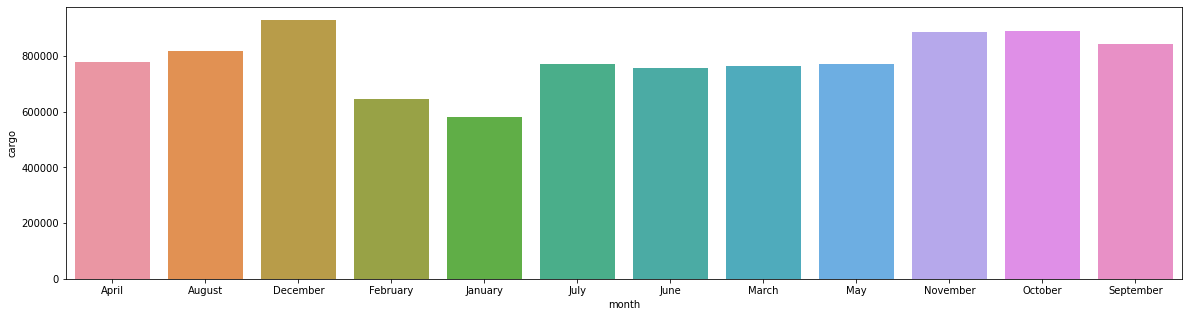

In [20]:
plt.figure(figsize=(20,5))
sns.barplot(data = df_per_month, x = 'month', y = 'cargo')

In [21]:
df.head(2)

,Airport name,Year,month,cargo
0,Abakan,2020,January,43.58
1,Aikhal,2020,January,0.00


I'll then convert the dates to a proper datetime format. 

In [31]:
df['date']=pd.to_datetime(df['Year'].astype(str)  + df['month'], format='%Y%B')

In [32]:
df.head()

,Airport name,Year,month,cargo,date
0,Abakan,2020,January,43.58,2020-01-01
1,Aikhal,2020,January,0.00,2020-01-01
2,Loss,2020,January,0.00,2020-01-01
3,Amderma,2020,January,0.00,2020-01-01
4,Anadyr (Carbon),2020,January,122.00,2020-01-01


In [43]:
df2=df.groupby('date')['cargo'].sum()
df2=df2.reset_index()

Since the data for each aiport is to less, I'll drop the airport and then calculate according to the total airline cargo volume.

In [48]:
# Python
import pandas as pd
from fbprophet import Prophet

X = pd.DataFrame({"ds":df2['date'],
                   "y":df2['cargo']})

### 3. Data Modelling

I will use Facebook's prophet library to perform the data modelling. 

In [83]:
m = Prophet()
m.fit(X)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
future = m.make_future_dataframe(periods=12, freq='M') #Monthly data for the next 12 months
future.tail()

,ds
175,2021-07-31
176,2021-08-31
177,2021-09-30
178,2021-10-31
179,2021-11-30


In [85]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,2021-07-31,38286.288446,19481.590646,57038.957335
176,2021-08-31,39964.672485,20703.784147,59103.980256
177,2021-09-30,43866.271661,25961.763000,62581.091774
178,2021-10-31,43960.305334,24784.700467,63362.259894
179,2021-11-30,46894.244658,28202.314349,63928.406002


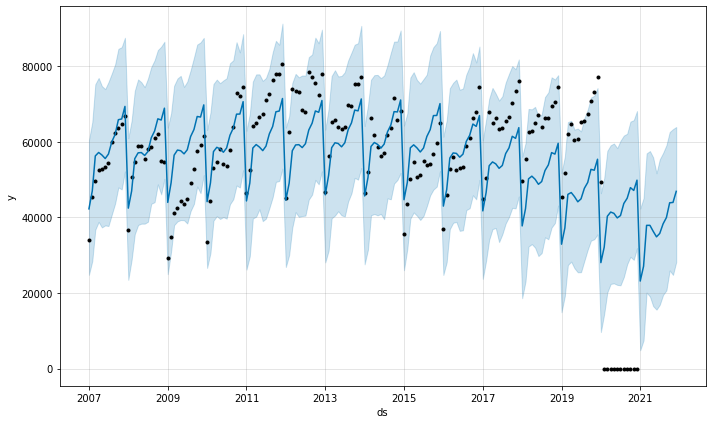

In [86]:
fig1 = m.plot(forecast)

As we can see in the above figure, the prediction for 2021 is less than 40000. 

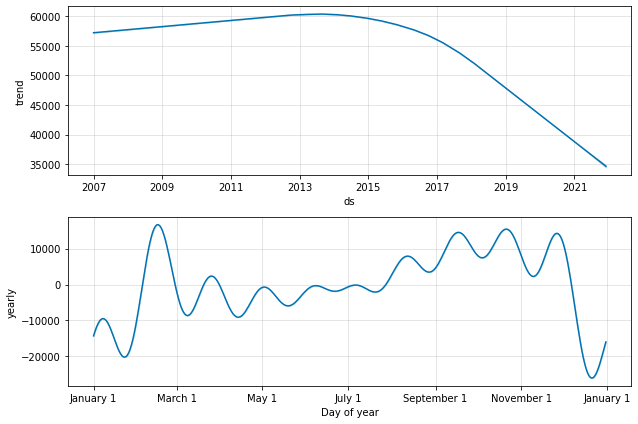

In [53]:
fig2 = m.plot_components(forecast)

It can be clearly observed in the rend that the cargo traffic will reduce drastically in 2021. 

Although due to the pandemic and the current year 2020 not being complete, there are huge outliers which skew the forecast. Hence, a better prediction will be if I take the data till 2019 and forecast the amounts for 2020 and 2021. 

In [55]:
X.tail()

,ds,y
163,2020-08-01,0.0
164,2020-09-01,0.0
165,2020-10-01,0.0
166,2020-11-01,0.0
167,2020-12-01,0.0


So, i'll filter out 20202

In [57]:
X_without_pandemic= X[X['ds']<'2020-01-01']

In [58]:
X_without_pandemic.tail()

,ds,y
151,2019-08-01,65431.94
152,2019-09-01,67362.54
153,2019-10-01,70742.14
154,2019-11-01,73215.60
155,2019-12-01,77269.41


In [87]:
m2 = Prophet()
m2.fit(X_without_pandemic)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
future = m2.make_future_dataframe(periods=24, freq='M')
future.tail()

,ds
175,2021-07-31
176,2021-08-31
177,2021-09-30
178,2021-10-31
179,2021-11-30


In [89]:
forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,2021-07-31,66470.821458,58937.462940,73535.199011
176,2021-08-31,68722.963561,61740.495596,75759.112358
177,2021-09-30,72224.290519,65418.693029,78869.663756
178,2021-10-31,73928.007747,66491.023088,81275.303059
179,2021-11-30,76897.940018,69764.649612,84322.927296


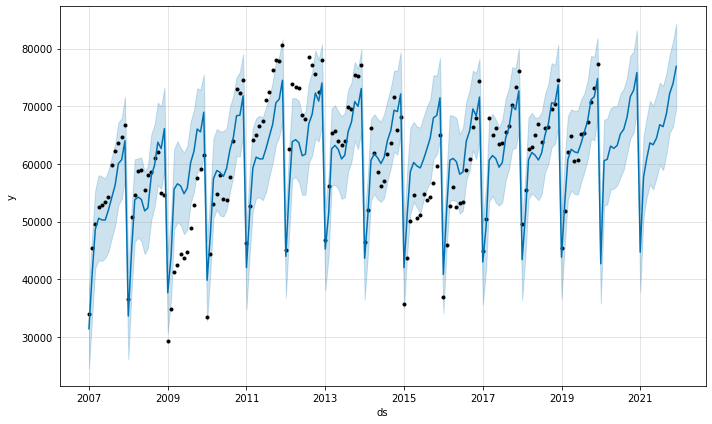

In [90]:
fig1 = m2.plot(forecast)

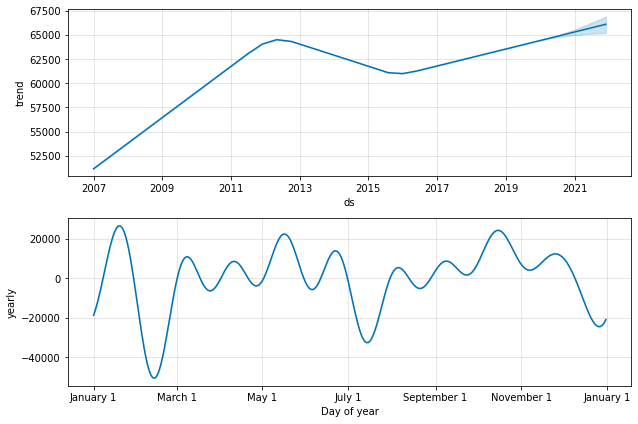

In [91]:
fig2 = m2.plot_components(forecast)

The forecast here is much more predictable and understandably the trend increases. 

Let's see what values we get for the current month June in both 2020 and 2021. 

In [94]:
forecast[forecast.ds=='2020-06-30'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
162,2020-06-30,65194.405823,57717.021522,72165.366203


In [95]:
forecast[forecast.ds=='2021-06-30'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
174,2021-06-30,66808.865745,59854.037356,74118.784143
